In [1]:
import sys
sys.path.append('C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive')
print(sys.path)  # Esto mostrará todas las rutas en sys.path

from model.training import ModelTrainer 
from model.inferences import ModelMetrics
from model.utils.data_extraction import DataExtractor
import numpy as np


['C:\\Users\\juans\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\juans\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\juans\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\juans\\AppData\\Local\\Programs\\Python\\Python312', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv', '', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\Pythonwin', 'C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive']


In [3]:
trainer = ModelTrainer()
model = trainer.run()

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.9985    | 0.07553   | 48.03     | 785.6     |
| 2         | 0.9986    | 0.1201    | 16.24     | 324.8     |
| 3         | 0.9986    | 0.1418    | 18.03     | 326.8     |
| 4         | 0.9985    | 0.09111   | 49.94     | 200.3     |
| 5         | 0.9987    | 0.1584    | 10.06     | 474.6     |
| 6         | 0.9985    | 0.1196    | 49.19     | 564.3     |
| 7         | 0.9987    | 0.07806   | 49.56     | 433.0     |


FileNotFoundError: [Errno 2] No such file or directory: '../model/trained_modelsstacking/stacking_model.pkl_2024-09-03_15-05-16.pkl'

In [ ]:
DataExtractor.save_model('../trained_models/', model, 'stacking/', 'stacking_model.pkl')

Index(['Edad', 'Autopercepcin Salud', 'Estado Civil', 'Escolaridad',
       'Ocupacin', 'MEPOC', 'Tipo problema auditivo', 'Tipo problema visuales',
       'Tipo enfermedad psiquitrica', 'Antecedentes Familiares Otros',
       'Lawton Pre Usar Telefono', 'Lawton Act Usar Telefono',
       'Lawton Act Manejar Dinero', 'Lawton Act Hacer Propia Comida',
       'Lawton Act Trabajo Liviano Casa', 'Lawton Act Trabajo Pesado Casa',
       'Total Lawton Actual Sin Dificultad',
       'Total Lawton Actual Con Dificultad', 'Total Lawton Actual Con Ayuda',
       'Total Gds', 'Cdr Memoria', 'Cdr Orientacion', 'Cdr Juicio',
       'Cdr Vida Social', 'Cdr Hogar Y Aficiones', 'Cdr Cuidado Personal',
       'Total Cdr', 'Mdico Atencin'],
      dtype='object')
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       228
           1       1.00      0.96      0.98        45
           2       1.00      1.00      1.00         7

   

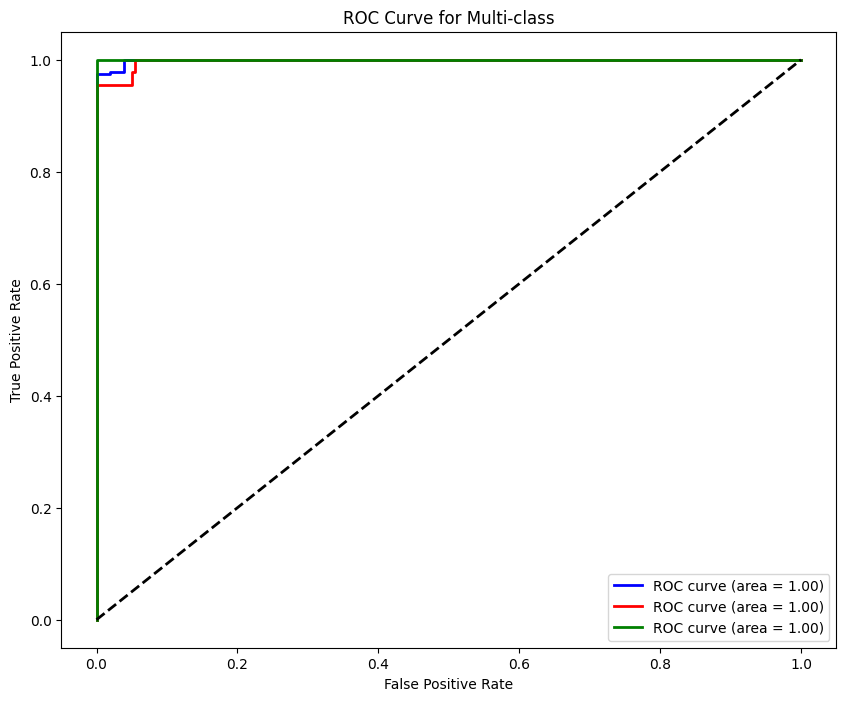

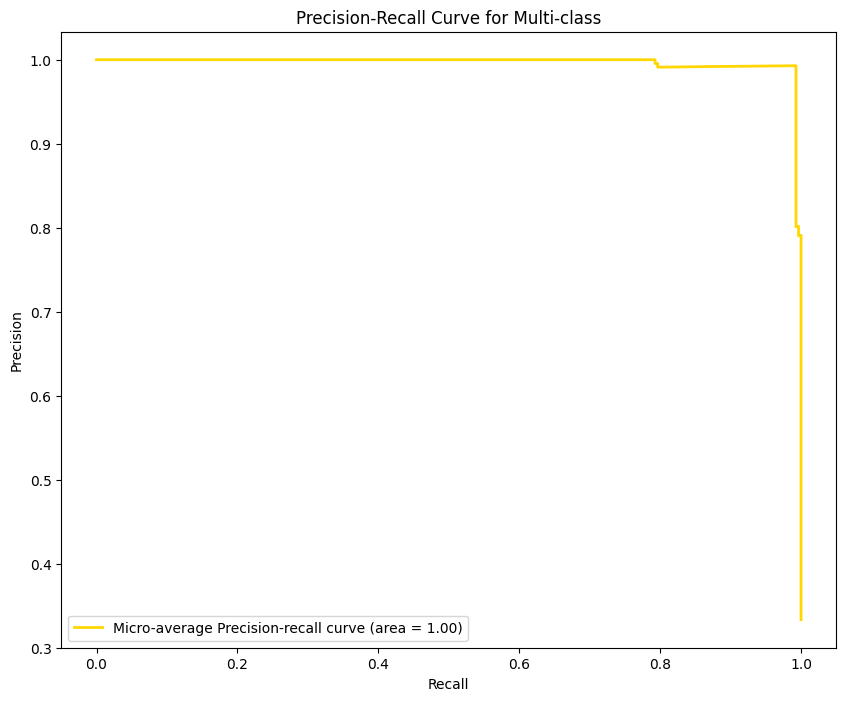

F1 Score: {f1:.2f}


In [7]:

# Ejemplo de cómo utilizar esta clase:
# Supón que ya has cargado tus datos y entrenado tu modelo, entonces puedes hacer lo siguiente:
data = trainer.data
new_X_test = trainer.X_test
new_y_test = trainer.y_test
n_classes = len(np.unique(new_y_test))

print(new_X_test.columns)

metrics = ModelMetrics(trainer.model, new_X_test, new_y_test, n_classes)
metrics.print_classification_report()
metrics.plot_roc_curve()
metrics.plot_precision_recall_curve()
metrics.print_f1_score()
